# WorkQueue Jupyter Tutorial

## Overview

Welcome to WorkQueue!  This tutorial is made for first time users who want to unlock the power of distributed computing, in tools that you're already familiar with, like Python and Jupyter.  If that's you, then you've come to the right place.  In this tutorial, you will learn about the need for distributed computing, the power of WorkQueue, and how we can write Python programs to use WorkQueue.

When you feel like you've managered the basics, have a look at our <a href="https://cctools.readthedocs.io/en/latest/work_queue/">documentation</a> for more detailed information about WorkQueue's advanced capabilities.

And of course, if you have any questions, comments, or suggestions, please visit our <a href="https://cctools.readthedocs.io/en/latest/help/">get help</a> page.  Here, you can access manuals, ask questions in the forum, and submit patches and issues.  We'd love to hear from you!

Let's get started.

## Distributed Computing in WorkQueue

### What is distributed computing, and why do we need it?

Distributed computing is the practice of using multiple computers that work together to accomplish some task, while essentially masking this behavior to the user.  This practice is extraordinarily common in systems that have to do lots of data processing.  For example, think about what happens when you upload a picture to Instagram.  A large number of functions are being called in the backend on Instagram's servers in order to update your profile, write your caption, post your picture, link the caption with the picture, notify tagged friends, associate the post with your hashtags and location, and so much more.  And every second, <a href="https://www.internetlivestats.com/one-second/">953 posts are made to Instagram</a>.  If all of these functions for all of these posts were executed sequentially on a single computer, the users would never see the end of their loading bars.  Instead, Instagram employs distributed computing to run these functions on a massive number of computers, simultaneously.  Making this work is exceedingly difficult, as it requires all the computers to be perfectly in sync with one another, resolve conflicts, and aggregate data on one user's phone in the end.  But, the ordinary Instagram user takes for granted the immediate speed at which their picture was uploaded for their friends to see.

Distributed computing can be used in a variety of settings far beyond social media data processing.  Any task that is using lots of data, performing a large number of calculations, or calling a bounty of functions can potentially be sped up using distributed computing.  In scientific research, for example, a massive number of calculations are often needed in order to create precise models, make a new discovery, or prove a theorem.  If the calculations can be split up logically, performed in parallel, and aggregated at the end, then the scientist can take advantage of distributed computing to reduce their computation time astronomically.

### What is the power of WorkQueue?

WorkQueue is powerful because *it makes distributed computing easy.*  With a simple yet versatile interface, WorkQueue provides a logical structure to split up complex tasks and aggregate results.  WorkQueue is extremely fast, fault tolerant, and fun.

The interface essentially boils down to a Master and a bunch of Workers.  The Master program controls the tasks that need to be completed, and the Workers actually perform those tasks.  In the Master, you create a task queue (`q = WorkQueue()`), then add tasks to it (`task = q.submit()`), then wait for the tasks to be completed by Workers (`completed_task = q.wait()`).  The Workers are easy to create, and once you connect them to the Master, they will automatically begin processing the tasks in your queue.  That's it.  It's really just about that easy!

## Writing Python Programs with WorkQueue

### Installation and Import

To begin, let's make sure that WorkQueue is properly installed.  Try importing it below, and if something's wrong, then go back and make sure you followed all the steps for the proper installation and setup.  You can also check out the <a href="https://cctools.readthedocs.io/en/latest/install/">installation instructions</a> for help.

In [ ]:
try:
    import work_queue as wq
    print("Congrats! WorkQueue is properly installed :)")
except:
    print("Uh oh. Something's wrong :(")

WorkQueue's default port is **9123**.  Try running the following command to be sure that WorkQueue was imported properly.

In [ ]:
port = wq.WORK_QUEUE_DEFAULT_PORT
print(port)

If WorkQueue was imported properly, then we're ready to start coding up a manager program.

### Writing a WorkQueue Master

As we know, there are two separate elements to WorkQueue programs running.  The first element is the Master, which is used to control all the tasks you want to complete.  The second element is the Worker, which completes the tasks.  There can be as many Workers as you would like, and they can be reused after they complete a task.  But, there can only be one Master program.

The WorkQueue Master is the "controller."  It controls when tasks are to be completed, who they can be completed by, and subsequently delegates the tasks to Workers who connect to the Master.

In the Master, we create a **task queue** and add a bunch of tasks to it.  These tasks could be big, small, or anywhere in between, and you can specify what kind of requirements (like memory, cores, etc.) these tasks need in order to run.  The manager will wait for workers to connect via its port, then properly delegate tasks to workers who can accommodate each task.  When a worker finishes, the manager program will accumulate its outputs, and the worker can then be reused on another task.

In a nutshell, the basic outline of a WorkQueue manager is:

1. Create and configure the task queue.
2. Create tasks and add them to the queue.
3. Wait for tasks to complete.

#### 1. Create and configure the tasks' queue
Try creating a new **task queue**, listening for Workers on port 9123, by running the following command.

(Only run this once. It will fail if you try to allocate a port you are already listening on.)

In [ ]:
q = wq.WorkQueue(port)

Great!  At this point, we could further configure this queue in many different ways; for example, we could set up monitoring or enforce passwords from workers.  In this tutorial, we will stick with the basic, default queue that we're given, and move on to adding tasks to the queue.

#### 2. Create tasks and add them to the queue

##### Generating input files and specifying output files

In this example, we will create three tasks.  Each task will take an input file containing some text and produce an output file of that text reversed, using the `rev` command line utility that reverses text (`rev` will also be passed to the Worker as an "input file").  Run the following lines of code to create three input files containing some text.

In [ ]:
infiles = ['file0.txt', 'file1.txt', 'file2.txt']
for i, f in enumerate(infiles):
    fh = open(f, 'w')
    fh.write('This is file number {}.'.format(i))
    fh.close()

When working at the command line, we can usually execute the `rev` utility by simply typing its name then the name of the file we want to reverse.  However, this is not enough for WorkQueue; we must specify precisely which files need to be transmitted to the workers.  We record the location of `rev` in `'rev_path'`, which is usually found in `/bin/rev` or `/usr/bin/rev`.  This file will be considered another input file for the task, since it is used to produce the desired output file.

In [ ]:
import os
rev_path = "/bin/rev"
if not os.path.exists(rev_path):
    rev_path = "/usr/bin/rev"
    if not os.path.exists(rev_path):
        print('Cannot find rev. Please modify rev_path \
        according to where it is installed in your system. \
        This can be determined by running "which rev".')

print(rev_path)

We will name our output files as `file#.txt.reversed`.  It is necessary to specify output files so that the Master knows which files are important to save.

In [ ]:
outfiles = ['file0.txt.reversed', 'file1.txt.reversed', 'file2.txt.reversed']

##### Creating the Task objects and adding them to the Task Queue

Now, let's actually create our tasks.  Each task is simply created by calling the Task() constructor.  The only argument the constructor takes is a command, which the Worker will execute when it picks up the task.  In this case, our command will be `./rev file#.txt > file#.txt.reversed`.  Notice that our command is `./rev` rather than our `rev_path`.  This is because we are running the `rev` command remotely on the Worker.  The *local* path to our executable is stored in `rev_path`, whereas the *remote* path, the path that the Worker will use, is `./rev`, since it will store the file we pass to it in its home directory.

After we create the task, we can add files to it using the function specify_files(), which takes (*local path*, *remote path*, *file type*, and *cache*) as arguments.  The *local path* is the path to the file on the Master's computer.  The *remote path* is the path to the file on the Worker's computer (usually in its current directory).  The *file type* is simply specifying whether this is an input file or an output file, and the values it can be are `WORK_QUEUE_INPUT` or `WORK_QUEUE_OUTPUT`.  The *cache* argument tells the Worker whether you want it to cache the file for reuse.  Essentially, if the Worker is going to be reused, and some file is needed for every single task that that Worker will take, then it is a waste of time to delete that file from the Worker after it has finished the first task, only to re-add the same file for the next task.  In our example, the `rev` executable input file will be used in every single worker, so we will want to cache it.

Finally, once we have specified all the files for the task, we can submit the task to the task queue we defined earlier using the submit() function, which returns an id for your task.

In [ ]:
for i in range(3):
    infile = infiles[i]
    outfile = outfiles[i]
    
    # Create a task by passing its constructor the command
    cmd = "./rev {} > {}".format(infile, outfile)
    t = wq.Task(cmd)
    
    # Specify input and output files for this task
    t.specify_file(rev_path, "rev", wq.WORK_QUEUE_INPUT, cache=True)
    t.specify_file(infile, infile, wq.WORK_QUEUE_INPUT, cache=False)
    t.specify_file(outfile, outfile, wq.WORK_QUEUE_OUTPUT, cache=False)
    
    # Submit the task to the task queue
    task_id = q.submit(t)
    print("Submitted task {}: {}".format(task_id, t.command))

#### 3. Wait for Tasks to Complete

Now, all we have to do in the Master is set up a while-loop that effectively waits for each task to be completed.  To do this, we will use two functions of the task queue: `empty()` and `wait()`.

The function `q.empty()` will return `True` if there are no more tasks left to complete in the task queue.  Initially, `q.empty()` should return `False`, since we just submitted three tasks to the queue.

The function `q.wait()` takes one argument, which is the amount of time in seconds we should wait for a task to complete.  This will return `null` if no tasks have been completed in that amount of time.  If one or more tasks have been completed, it will return a Task object for the completed task.

In [ ]:
while not q.empty():
    t = q.wait(5)
    if t:
        print("task (id# {}) complete: {} (return code {})".format(t.id, t.command, t.return_status))

print("all tasks complete!")

### Submit a Worker

If you have been following along so far, the above cell will not terminate running (you should see [ * ] to the left of the cell), since it is waiting for tasks to complete.  At this point, the Master is waiting for Workers to connect to it.  Now, we need to open up a terminal and submit a Worker to perform the tasks we created.  To do this, we create a Worker with the command line utility `work_queue_worker`, and pass it options for the name of the machine your Master is running on, and the port you selected at the beginning (remember, the default port for WorkQueue is 9123).  Let's go ahead and submit one Worker by opening up a terminal and running the following command:

`work_queue_worker localhost 9123`

(This assumes that you are running the command on the same computer that your Jupyter Notebook is running on.  If this is not the case, replace `localhost` with the name of your machine.)

After running this command, the Worker you just submitted will connect to the Master program you have been writing during this tutorial.  The Master allocates the first task to the Worker, and then the Worker returns its output file to the Master.  After this, the same Worker takes up the next tasks sequentially until it has no more tasks to complete.

Once you see that all tasks have been completed in the above cell, go ahead and use `ctrl-C` to kill the Worker in the terminal.

### Observing the Results

Congratulations!  You have now written your first WorkQueue Master!  Let's take a look at our results by reading the output files that have now been created inside of your Master's directory.

In [ ]:
files = [open("file{}.txt.reversed".format(i)) for i in range(3)]
for f in files:
    for line in f:
        print(line)

## Beyond the Basics

Now that we have the feel for the basics of WorkQueue, let's take a look at the ways in which we can use WorkQueue to actually enhance the speed of your tasks, and the ease of doing your business.  So far, you have run your Master program on your local computer, and you have connected a Worker on to the Master on the same local computer; there is a bit more to learn about this (1).  But, distributed computing is all about taking advantage of the processing power of a cluster of computers.  To learn how to do this, we will start by learning how to run your Master Notebook remotely, and connecting a Worker to it on the same remote computer (2).  After that, we will try to submit one Worker to a cluster from your remote Master (3).  Finally, we will submit multiple Workers to a cluster from your remote Master (4).

<div style="
        padding: 20px;
        background-color: #ff6700;
        color: white;
        margin: 15px;
        border-radius: 30px;
    ">
    <b style="font-size: 18px;">&#9758; TERMINOLOGY</b><br/>
    <p>In the following sections, in accordance with common practices, I might use the following terminology.  Don't let it confuse you!
    <ul>
        <li>Node: A computer</li>
        <li>Machine: Also a computer</li>
        <li>Cluster: A group of computers connected somehow</li>
        <li>Head (or head node): The node your Master is running on, the main node.</li>
    </ul>
    </p>
</div> 

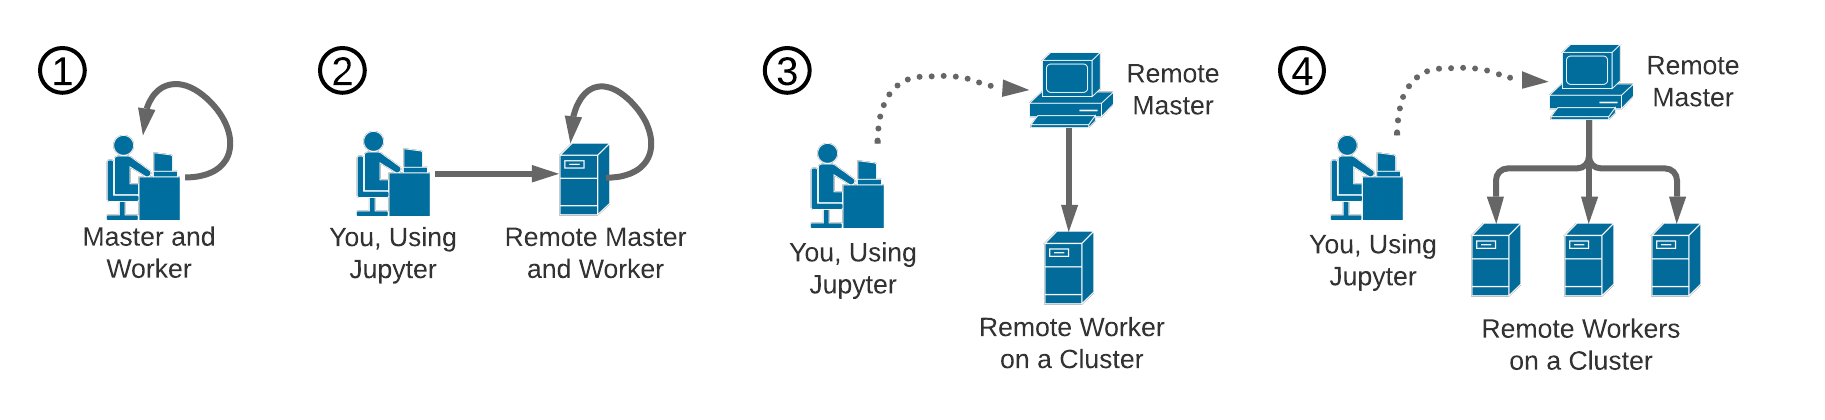

### 1. Local Master and Worker

Our basic example we just completed used this method.  We started up our Master on our local computer, then opened up a terminal also on our local computer, in order to submit a Worker that connected to our Master, all locally.  But, wouldn't it be nice if we could submit the Worker from our Jupyter Notebook instead of needing to open up a terminal?  We can do this, but it requires submitting our Worker before beginning the while loop that waits for the queue to be empty.  The Worker has to be ready to go, so that it can immediately begin accepting tasks when the Master calls `q.wait()`.

The reason?  When a cell in a Jupyter Notebook is run, it is executed line-by-line, and it blocks out all other cells from executing until the first cell has completed its execution entirely.  So, if you try to run a while loop waiting for the queue to be empty, but you don't yet have any Workers to do the tasks, then that cell will run forever, which prevents you from creating Workers in another cell.

Alternatively, one could absolutely use a separate Jupyter Notebook to submit Workers, and this will work no matter what you are doing in your Master Notebook.  It is highly encouraged to use this approach in your actual applications, so that you can have full autonomy over your Workers; you can create them on demand and kill them on demand no matter what is executing in your Master Notebook.  In this tutorial, though, we will do everything here for the sake of keeping everything in one document.

WorkQueue provides no actual function to submit a Worker, but we can open up a process (i.e. run something from the command line) within Python using the `popen` (stands for "process open") function in the `os` library, which we've already imported.  So let's try it!

We will use the `tr` utility for the remainder of the tutorial (instead of `rev`), which translates text in a way that the user defines.  Our first application of it will be to make everything in the files uppercase.

First, run the following code to find the path to `tr`.

In [ ]:
# Find path to tr
import os
tr_path = "/bin/tr"
if not os.path.exists(tr_path):
    rev_path = "/usr/bin/tr"
    if not os.path.exists(tr_path):
        print('Cannot find tr. Please modify tr_path \
        according to where it is installed in your system. \
        This can be determined by running "which tr".')

print(tr_path)

Now, let's define our input and output files, then submit our tasks.

In [ ]:
# Identify infiles and outfiles
infiles = ['file0.txt', 'file1.txt', 'file2.txt']
outfiles = ['file0.txt.capitalized', 'file1.txt.capitalized', 'file2.txt.capitalized']

# Submit tasks
for i in range(3):
    infile = infiles[i]
    outfile = outfiles[i]
    
    # Create a task by passing its constructor the command
    cmd = './tr "[a-z]" "[A-Z]" < {} > {}'.format(infile, outfile)
    t = wq.Task(cmd)
    
    # Specify input and output files for this task
    t.specify_file(tr_path, "tr", wq.WORK_QUEUE_INPUT, cache=True)
    t.specify_file(infile, infile, wq.WORK_QUEUE_INPUT, cache=False)
    t.specify_file(outfile, outfile, wq.WORK_QUEUE_OUTPUT, cache=False)
    
    # Submit the task to the task queue
    task_id = q.submit(t)
    print("Submitted task {}: {}".format(task_id, t.command))

Before we begin the process of waiting for tasks to complete, we will submit a worker using `os.popen()`.  Remeber, we *must* do this first to avoid the drawbacks outlined above.

In [ ]:
os.popen('work_queue_worker localhost {}'.format(port))

If you obtain an output that looks something like `<open file 'work_queue_worker localhost 9123', mode 'r' at 0x0123456789ab>`, then your command was executed properly.

Now that you've created a Worker on the local machine, let's begin waiting for our tasks to complete!  This should execute immediately, since we have already submitted the Worker.

In [ ]:
while not q.empty():
    t = q.wait(5)
    if t:
        print("task (id# {}) complete: {} (return code {})".format(t.id, t.command, t.return_status))

print("all tasks complete!")

And finally, let's observe our results.

In [ ]:
files = [open("file{}.txt.capitalized".format(i)) for i in range(3)]
for f in files:
    for line in f:
        print(line)

Congrats! Now you know how to submit a Worker from the Jupyter Notebook itself.  But, as you might have noticed, that Worker is still running in the background, waiting for more tasks to complete.  WorkQueue Workers will automatically terminate after 15 minutes of being idle, and you can set this timeout to something else by passing the `-t [time]` option to `work_queue_worker` (for example, run `work_queue_worker -t 60` to set the timeout to 1 minute).  However, you might want to kill these processes immediately.  The simplest way to achieve this is by running `killall work_queue_worker` at the command line.  You can use `os.popen()` to do this from the Jupyter Notebook.  Try it out below.

In [ ]:
os.popen('killall work_queue_worker')

### 2. Master on a Remote Head Node, Worker on the Same Node

Now that we're experts on running a Master and a Worker locally, let's look at doing this on a remote machine.  For this part, you will need to have access to some other computer via SSH.  Before continuing, make sure that you know your credentials for accessing your remote computer through SSH.

In order to keep using Jupyter Notebook on your local computer while doing your processing on a remote machine, we need to set up an SSH tunnel.  You don't really need to worry about what this means or how it works, but if you're curious, <a href="https://www.ssh.com/ssh/tunneling/example">check this out</a>.  Otherwise, just follow these steps:

<div style="
        padding: 20px;
        background-color: #4BB543;
        color: white;
        margin: 15px;
        border-radius: 30px;
    ">
    <b style="font-size: 18px;">&#9758; REMOTE NOTEBOOK STEPS</b><br/>
    <ol>
        <li>Open up a terminal on your local computer.</li>
        <li>Run this command: <span style="background-color: #cccccc; color: black; font-family: courier;">ssh -L 8001:localhost:8001 &lt;REMOTE_USER&gt;@&lt;REMOTE_MACHINENAME&gt;</span> (replace <span style="background-color: #cccccc; color: black; font-family: courier;">&lt;REMOTE_USER&gt;</span> with your username and <span style="background-color: #cccccc; color: black; font-family: courier;">&lt;REMOTE_MACHINENAME&gt;</span> with the name of the remote machine).
            <ul>
                <li>Here, we are using port 8001 for the tunnel.  If this port is already in use on either your local computer or remote machine, just use a different port.  I recommend choosing something in the 8000s for this functionality.</li>
            </ul>
        </li>
        <li>Once you've entered your credentials, your terminal should now have you in your remote machine.  Navigate to the directory you want to use for WorkQueue applications.</li>
        <li>Now it's install time (skip this step if you already have everything installed and downloaded).  Either download this tutorial into your chosen directory, just like you did when you downloaded the tutorial locally, or use sftp to transfer the file you were working on locally into this remote folder.  If you haven't installed WorkQueue yet on your remote machine, install it here, too.  You will also need to make sure Jupyter is installed.  That's <b><u>three things</u></b> you need to make sure are installed correctly, again, just on your remote machine this time.
            <ul>
                <li>If you need a refresher on how to install WorkQueue again with all the necessary components, please revisit the instructions you followed right before beginning this tutorial.  If you need any additional help, <a href="https://cctools.readthedocs.io/en/latest/install/" style="color: white;">click here.</a></li>
                <li>Jupyter can usually be installed by running <span style="background-color: #cccccc; color: black; font-family: courier;">pip install jupyter</span>, but it should already be available for you if you are using an Anaconda/miniconda environment.  If it's not, then run <span style="background-color: #cccccc; color: black; font-family: courier;">conda install jupyterlab</span></li>
                <li>Again, this tutorial notebook can be downloaded <u style="background-color: yellow; color: black;">here</u>, or you can run <span style="background-color: #cccccc; color: black; font-family: courier;">wget</span><span style="background-color: yellow; color: black;">LOCATION/OF/NOTEBOOK</span></li>
            </ul>
        </li>
        <li>Run this command: <span style="background-color: #cccccc; color: black; font-family: courier;">jupyter notebook --no-browser --port=8001</span>.  If you used a different port in your first command, replace 8001 with your port.</li>
        <li>Finally, copy and paste the URL produced into your browser (the one that looks like http://localhost:8001/?token=abcdef...).  You should see your remote directory tree pop up.  Open your tutorial, and scroll on back down to this cell.  You might want to select this cell, then go to the "Cell" tab above, and click "Run All Above" to redefine your variables, reimport libraries, and recreate all the files you have already created.  Alternatively, this would be a good time just to go back through the tutorial to refresh yourself, if you have any confusion so far.
    </ol>
</div> 

Once you're all set up to work in your Jupyter Notebook connected to the remote machine, we can continue.

In this example, we will use `tr` to put each word on its own line.  Again, begin by defining your input and output files, and submitting your tasks to the task queue.

In [ ]:
# Identify infiles and outfiles
infiles = ['file0.txt', 'file1.txt', 'file2.txt']
outfiles = ['file0.txt.newlines', 'file1.txt.newlines', 'file2.txt.newlines']

# Submit tasks
for i in range(3):
    infile = infiles[i]
    outfile = outfiles[i]
    
    # Create a task by passing its constructor the command
    cmd = './tr " " "\n" < {} > {}'.format(infile, outfile)
    t = wq.Task(cmd)
    
    # Specify input and output files for this task
    t.specify_file(tr_path, "tr", wq.WORK_QUEUE_INPUT, cache=True)
    t.specify_file(infile, infile, wq.WORK_QUEUE_INPUT, cache=False)
    t.specify_file(outfile, outfile, wq.WORK_QUEUE_OUTPUT, cache=False)
    
    # Submit the task to the task queue
    task_id = q.submit(t)
    print("Submitted task {}: {}".format(task_id, t.command))

Now start a worker...

In [ ]:
os.popen('work_queue_worker localhost {}'.format(port))

Now wait for tasks to complete...

In [ ]:
while not q.empty():
    t = q.wait(5)
    if t:
        print("task (id# {}) complete: {} (return code {})".format(t.id, t.command, t.return_status))

print("all tasks complete!")

Now observe your results...

In [ ]:
files = [open("file{}.txt.newlines".format(i)) for i in range(3)]
for f in files:
    for line in f:
        print(line)

Now kill your Worker...

In [ ]:
os.popen('killall work_queue_worker')

Great work!  Now, we will get our Worker to run on a machine that's different from the Master.

### 3. Master on a Remote Head Node, One Worker on a Remote Machine

Now that we have the hang of submitting a Worker to the same computer as your Master (whether that computer is your local computer or your remote computer), let's learn how to submit a Worker to a separate machine from your Master.  There are two ways to go about this.  The first way is to use `ssh` to log in to another computer that also has WorkQueue then execute `work_queue_worker <MACHINE_NAME> 9123`, where `<MACHINE_NAME>` is the node that is hosting the Master Notebook.  The second way to do this is by submitting a Worker to a cluster.  There are 6 common clusters that WorkQueue currently supports, and the command line utility to submit Workers to them are as follows:

- HTCondor: `condor_submit_workers`
- SGE: `sge_submit_workers`
- PBS: `pbs_submit_workers`
- Torque: `torque_submit_workers`
- Slurm: `slurm_submit_workers`
- ec2: `ec2_submit_workers`

<div style="
        padding: 20px;
        background-color: #ff6700;
        color: white;
        margin: 15px;
        border-radius: 30px;
    ">
    <b style="font-size: 18px;">&#9758; CLUSTER USAGE</b><br/>
    <p>You must have special access to a cluster in order to use it.  Talk to your network administrator to find out which clusters are available to you.
    </p>
</div> 

The way to invoke these cluster utilities is as follows:

`<CLUSTER>_submit_workers <MACHINE_NAME> <PORT> <NUMBER_OF_WORKERS>`

Let's try submitting one Worker to a cluster in order to remove the spaces from our file.  But first, let's define variables for the `cluster` and `machine_name` that work for you.

In [ ]:
# Assign your cluster "condor", "sge", "pbs", "torque", "slurm", or "ec2"
cluster = "condor"

# Assign your machine name
machine_name = "REMOTE.MACHINE.NAME"

In [ ]:
# Identify infiles and outfiles
infiles = ['file0.txt', 'file1.txt', 'file2.txt']
outfiles = ['file0.txt.chained', 'file1.txt.chained', 'file2.txt.chained']

# Submit tasks
for i in range(3):
    infile = infiles[i]
    outfile = outfiles[i]
    
    # Create a task by passing its constructor the command
    cmd = './tr -d " " < {} > {}'.format(infile, outfile)
    t = wq.Task(cmd)
    
    # Specify input and output files for this task
    t.specify_file(tr_path, "tr", wq.WORK_QUEUE_INPUT, cache=True)
    t.specify_file(infile, infile, wq.WORK_QUEUE_INPUT, cache=False)
    t.specify_file(outfile, outfile, wq.WORK_QUEUE_OUTPUT, cache=False)
    
    # Submit the task to the task queue
    task_id = q.submit(t)
    print("Submitted task {}: {}".format(task_id, t.command))

Notice that, below, we are using your cluster to submit 1 worker to your machine on the port that you are using.

In [ ]:
os.popen('{}_submit_workers {} {} 1'.format(cluster, machine_name, port))

In [ ]:
while not q.empty():
    t = q.wait(5)
    if t:
        print("task (id# {}) complete: {} (return code {})".format(t.id, t.command, t.return_status))

print("all tasks complete!")

In [ ]:
files = [open("file{}.txt.chained".format(i)) for i in range(3)]
for f in files:
    for line in f:
        print(line)

Awesome! Cleaning up Workers on a cluster involves invoking the command specific to that cluster to remove its processes.  For example, Slurm uses `scancel` and HTCondor uses `condor_rm`.  You can use `os.popen()` to kill your Workers using these commands, too.  In this tutorial, we will just let our cluster Workers time out (default is 15 minutes).

### 4. Master on a Remote Head Node, Multiple Workers on a Cluster

We have just seen how to submit one Worker to a cluster.  Now, let's try submitting multiple Workers.  We will use the same command, but we have to change the number of Workers we want to submit.  This time, let's use `tr` to replace vowels with special characters in our files.

We will submit 10 Workers to our cluster.  We can observe the benefit of using a cluster by looking at how long it takes to execute the commands.  Adding a `sleep 5` to our commands (before `tr`) forces the processes to take five seconds to complete.

When we actually wait for our Workers to complete the tasks, we will use the `time` library to see how long it takes for all of our tasks to complete.  If we were running all three tasks on one machine, it would take 15 seconds for them to complete.  Let's see what happens on the cluster...

In [ ]:
# Identify infiles and outfiles
infiles = ['file0.txt', 'file1.txt', 'file2.txt']
outfiles = ['file0.txt.special', 'file1.txt.special', 'file2.txt.special']

# Submit tasks
for i in range(3):
    infile = infiles[i]
    outfile = outfiles[i]
    
    # Create a task by passing its constructor the command
    cmd = 'sleep 5 && ./tr "aeiou" "@310-" < {} > {}'.format(infile, outfile)
    t = wq.Task(cmd)
    
    # Specify input and output files for this task
    t.specify_file(tr_path, "tr", wq.WORK_QUEUE_INPUT, cache=True)
    t.specify_file(infile, infile, wq.WORK_QUEUE_INPUT, cache=False)
    t.specify_file(outfile, outfile, wq.WORK_QUEUE_OUTPUT, cache=False)
    
    # Submit the task to the task queue
    task_id = q.submit(t)
    print("Submitted task {}: {}".format(task_id, t.command))

In [ ]:
os.popen('{}_submit_workers {} {} 10'.format(cluster, machine_name, port))

In [ ]:
import time

start = time.time()

while not q.empty():
    t = q.wait(5)
    if t:
        print("task (id# {}) complete: {} (return code {})".format(t.id, t.command, t.return_status))

end = time.time()
elapsed = end - start

print("all tasks complete in {:.2f} seconds!".format(elapsed))

In [ ]:
files = [open("file{}.txt.special".format(i)) for i in range(3)]
for f in files:
    for line in f:
        print(line)

If everything worked properly, you should see that all the tasks were completed in just over 5 seconds.  This indicates that three separate Workers on the cluster must have picked up the three tasks that the Master submitted to its queue.  If only one machine was running these tasks sequentially, it would have taken 15 seconds.  This is the power of distributed computing!  You can perform multiple tasks at the same time, dramatically reducing the time needed for your processing, and it's easy to implement with WorkQueue.

With this milestone, you have officially earned the rank of <b style="font-family: courier;"><i>Distributed Computing Magician.</i></b>  Good for you!  Here is your certificate.

## Parsl and Coffea

If you like to use Parsl and Coffea, and you would like to know how to incorporate WorkQueue with these applications, read on!

### Parsl

Parsl is a Python library developed at the University of Chicago that enables users to easily write Python applications that run in parallel through a variety of computational backends, including Work Queue. Users write Python functions, called 'apps', which can be connected together to build large, parallel workflows for your application. Parsl handles all input and output data dependencies between the different tasks within the workflow, allowing the user to benefit from drastically increased throughput without having to worry the intricacies of transferring data. 

Currently, Using Parsl with Work Queue is only available on Linux host machines. To install Parsl, run the following command at the terminal: `pip3 install parsl`

Creating a Parsl workflow with Work Queue as an execution backend is straightforward. First, we need to import the Parsl library and the appropriate configuration files for both Parsl and Work Queue:

In [ ]:
import parsl
import os 
from parsl.app.app import python_app
from parsl.configs.wqex_local import config

And load the configuration file to let Parsl know we want to use Work Queue as the execution backend:

In [ ]:
parsl.load(config)

To specify what Python code is run within the Parsl program, we write a 'Python app', a 'pure' Python function that can be remotely executed. To write a Python app, we decorate the function with `@python_app`. Let's write an example Parsl workflow that returns the square of a number ten times, done in parallel. First, we create the Python app that will be executed by a Work Queue worker:

In [ ]:
@python_app
def square(a):
    return a * a

The easiest way to run Parsl apps in parallel is via looping. Within the loop, we first make a call to the Python app to submit the function to execute within Work Queue, and later call the Python app's `result()` method, which waits for execution to complete and returns its result. Here, we iterate through numbers 0 through 9 to find the square of each number, in parallel, and then wait for the result of the execution:

In [ ]:
squares = []
for i in range(10):
    squares.append(square(i))
    
outputs = [i.result() for i in squares]
print(outputs)

Finally, we can use a cluster to submit 10 Work Queue workers to our Parsl application, which will execute the tasks and return the results:

In [ ]:
os.popen('{}_submit_workers {} {} 10'.format(cluster, machine_name, port))

Notice how the original for loop simply submits the function to be executed by Work Queue, but does not wait for it's result before submitting the next task. Thus, all 10 instances of the Parsl app are submitted in parallel to Work Queue, and we use the output list to obtain their results as they complete. Using Parsl, we can easily build large Python workflows that can run concurrently using the power of Work Queue's distributed framework, drastically increasing throughput for your application!

This is merely an introduction to the Parsl library using Work Queue as its execution environment. To learn more about the power of Parsl, including how to specify input dependencies, run command line programs (`@bash_apps`), and link apps with each other, please refer to the [Parsl tutorial](https://parsl.readthedocs.io/en/stable/parsl-introduction.html).

## License

Work Queue is Copyright (C) 2016- The University of Notre Dame. All rights reserved. This software is distributed under the GNU General Public License. See the file COPYING for details. 